In [1]:
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random
from scipy.stats import norm

import os
import pathlib

from Model import *
from utils import *

torch.autograd.set_detect_anomaly(True)
start_time=datetime.now().strftime('%B %d - %H:%M:%S')

In [2]:
#Global parameters 
GlobalParams1=Params(param_type='k1',target_type='sigmoid',trick='clamp',loss_type='MSELoss',delta=0.03,w=1,lr=0.001)
dB1 = SampleBMIncr(GlobalParams=GlobalParams1)
init_x1 =  Sample_Init(GlobalParams=GlobalParams1)
init_c1= torch.zeros_like(init_x1)

GlobalParams2=Params(param_type='k2',target_type='sigmoid',trick='clamp',loss_type='MSELoss',delta=0.03,w=1,lr=0.001)
dB2 = SampleBMIncr(GlobalParams=GlobalParams2)   ## TODO: same dB?????
init_x2 =  Sample_Init(GlobalParams=GlobalParams2)
init_c2= torch.zeros_like(init_x2)

NT1=GlobalParams1.NT1
NT2=GlobalParams1.NT2
dt=GlobalParams1.dt
device=GlobalParams1.device
learning_rate = GlobalParams1.lr

#Forward Loss
forward_losses = []

#How many batches
MaxBatch= 500

#How many optimization steps per batch
OptimSteps= 25

#Train on a single batch?
single_batch = True

#Set up main models for y0, yt1, and z (z will be list of models)
y0_model_main1 = Network(scaler_type='sigmoid')
yt1_model_main1 = Network(scaler_type='sigmoid')
zy_models_main1 = [Network() for i in range(NT2)]
main_models1=Main_Models(GlobalParams=GlobalParams1)
main_models1.create(y0_model=y0_model_main1,
                    yt1_model=yt1_model_main1,
                    zy_models=zy_models_main1,
                    forward_loss=forward_losses,
                    dB=dB1,
                    init_x=init_x1,
                    init_c=init_c1)

y0_model_main2 = Network(scaler_type='sigmoid')
yt1_model_main2 = Network(scaler_type='sigmoid')
zy_models_main2 = [Network() for i in range(NT2)]
main_models2=Main_Models(GlobalParams=GlobalParams2)
main_models2.create(y0_model=y0_model_main2,
                    yt1_model=yt1_model_main2,
                    zy_models=zy_models_main2,
                    forward_loss=forward_losses,
                    dB=dB2,
                    init_x=init_x2,
                    init_c=init_c2)

pop1_dict={'dB':dB1,
           'init_x':init_x1 ,
           'init_c':init_c1 , 
           'GlobalParams':GlobalParams1, 
           'main_models':main_models1}

pop2_dict={'dB':dB2,
           'init_x':init_x2 ,
           'init_c':init_c2 , 
           'GlobalParams':GlobalParams2, 
           'main_models':main_models2}

In [3]:
#Define optimization parameters
params=[]
params = list(main_models1.y0_model.parameters())+\
         list(main_models1.yt1_model.parameters())+\
         list(main_models2.y0_model.parameters())+\
         list(main_models2.yt1_model.parameters())

for i in range(NT2):
    params += list(main_models1.zy_models[i].parameters())
    params += list(main_models2.zy_models[i].parameters())
    
#Set up optimizer and scheduler
optimizer = optim.Adamax(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

for k in range(0,MaxBatch):

    print("Batch Number: ", k+1)
    sloss=0
    #optimize main network wrt the foward loss
    for l in range(0,OptimSteps):
        optimizer.zero_grad()
        loss = get_foward_loss(pop1_dict=pop1_dict, pop2_dict=pop2_dict)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(parameters=params,max_norm=0.7)
        optimizer.step()
        scheduler.step()
        nloss = loss.detach().numpy()
        sloss += nloss
        # print('OptimStep: '+ str(l+1))
        # print('forward_loss: ' + str(nloss))
    avgloss = sloss/OptimSteps
    print("Average Error Est: ", avgloss)
    forward_losses.append(avgloss)

    #Generate a new batch if using multiple batches
    if(not single_batch):

        dB1 = SampleBMIncr(GlobalParams=GlobalParams1)
        init_x1 =  Sample_Init(GlobalParams=GlobalParams1)
        init_c1= torch.zeros_like(init_x1)
        pop1_dict={'dB':dB1,
                'init_x':init_x1 ,
                'init_c':init_c1 , 
                'GlobalParams':GlobalParams1, 
                'main_models':main_models1}

        dB2 = SampleBMIncr(GlobalParams=GlobalParams2)   ## TODO: same dB?????
        init_x2 =  Sample_Init(GlobalParams=GlobalParams2)
        init_c2= torch.zeros_like(init_x2)
        pop2_dict ={'dB':dB2,
                    'init_x':init_x2 ,
                    'init_c':init_c2 , 
                    'GlobalParams':GlobalParams2, 
                    'main_models':main_models2}
end_time=datetime.now().strftime('%B %d - %H:%M:%S')

Batch Number:  1
Average Error Est:  2.136925468444824
Batch Number:  2
Average Error Est:  1.9451089429855346
Batch Number:  3
Average Error Est:  1.7954975938796998
Batch Number:  4
Average Error Est:  1.6840017223358155
Batch Number:  5
Average Error Est:  1.5933487939834594
Batch Number:  6
Average Error Est:  1.5215121078491212
Batch Number:  7
Average Error Est:  1.4625796175003052
Batch Number:  8
Average Error Est:  1.4161210823059083
Batch Number:  9
Average Error Est:  1.3801909017562866
Batch Number:  10
Average Error Est:  1.3532455205917358
Batch Number:  11
Average Error Est:  1.332128963470459
Batch Number:  12
Average Error Est:  1.31429368019104
Batch Number:  13
Average Error Est:  1.2988125419616698
Batch Number:  14
Average Error Est:  1.2849519205093385
Batch Number:  15
Average Error Est:  1.272166314125061
Batch Number:  16
Average Error Est:  1.2605424690246583
Batch Number:  17
Average Error Est:  1.2505850219726562
Batch Number:  18
Average Error Est:  1.24232

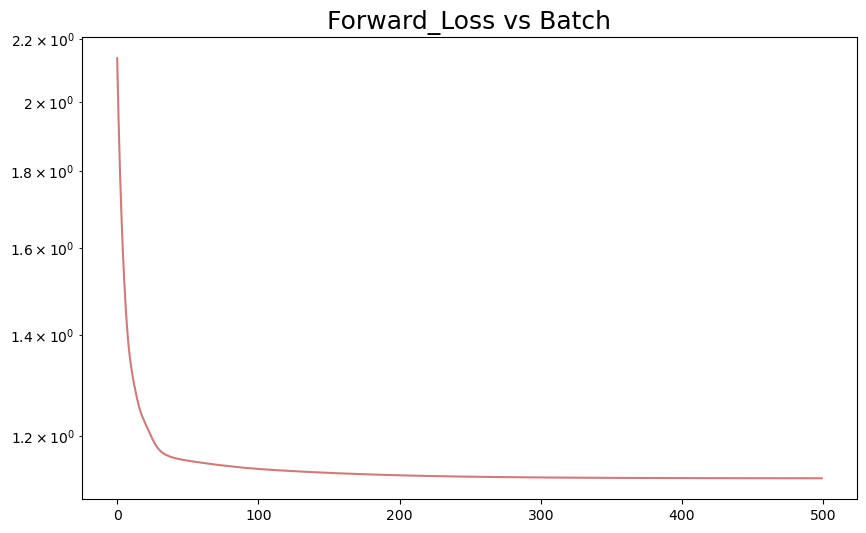

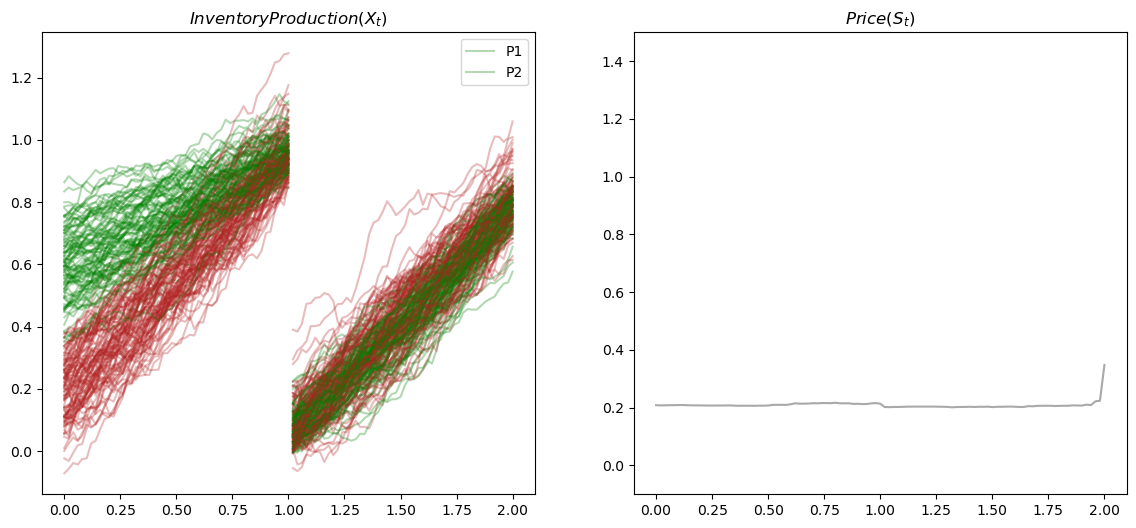

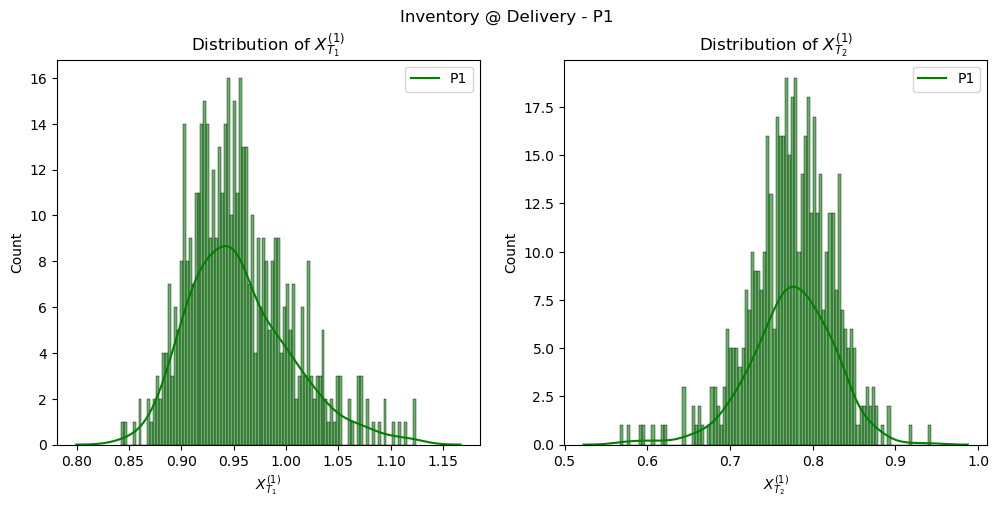

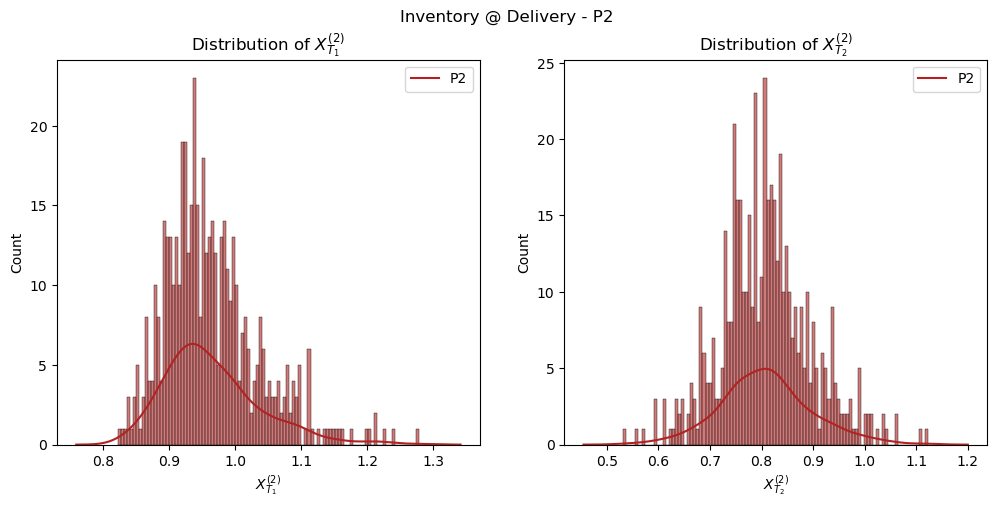

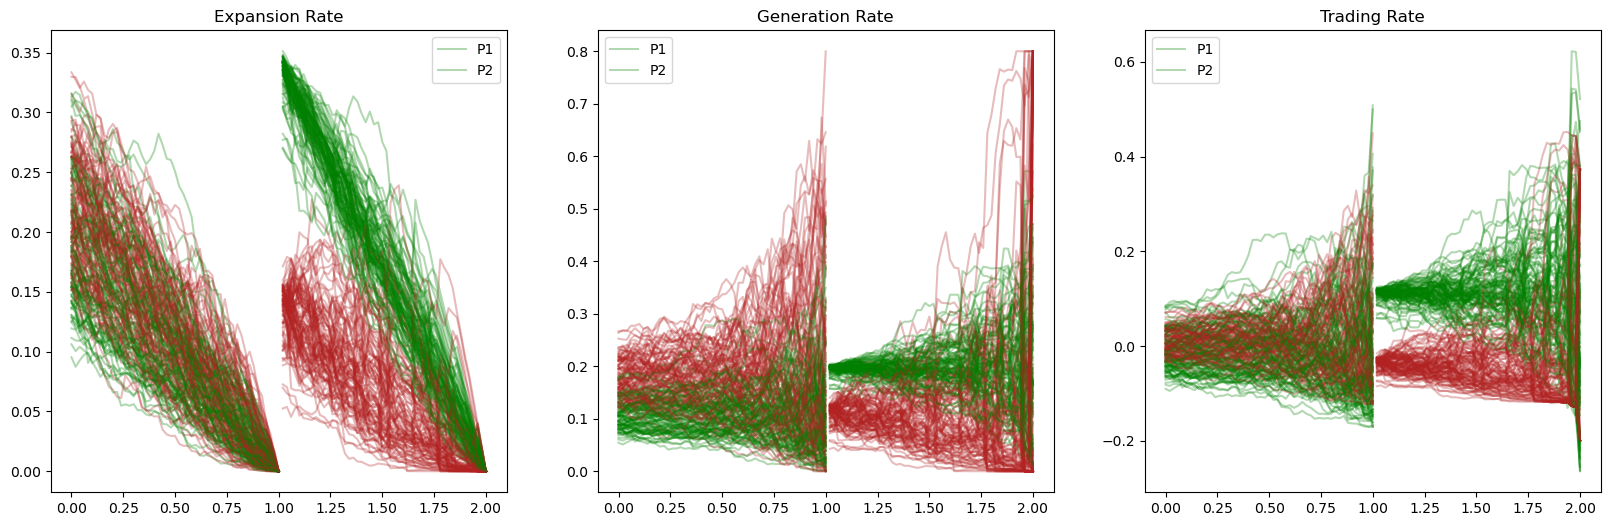

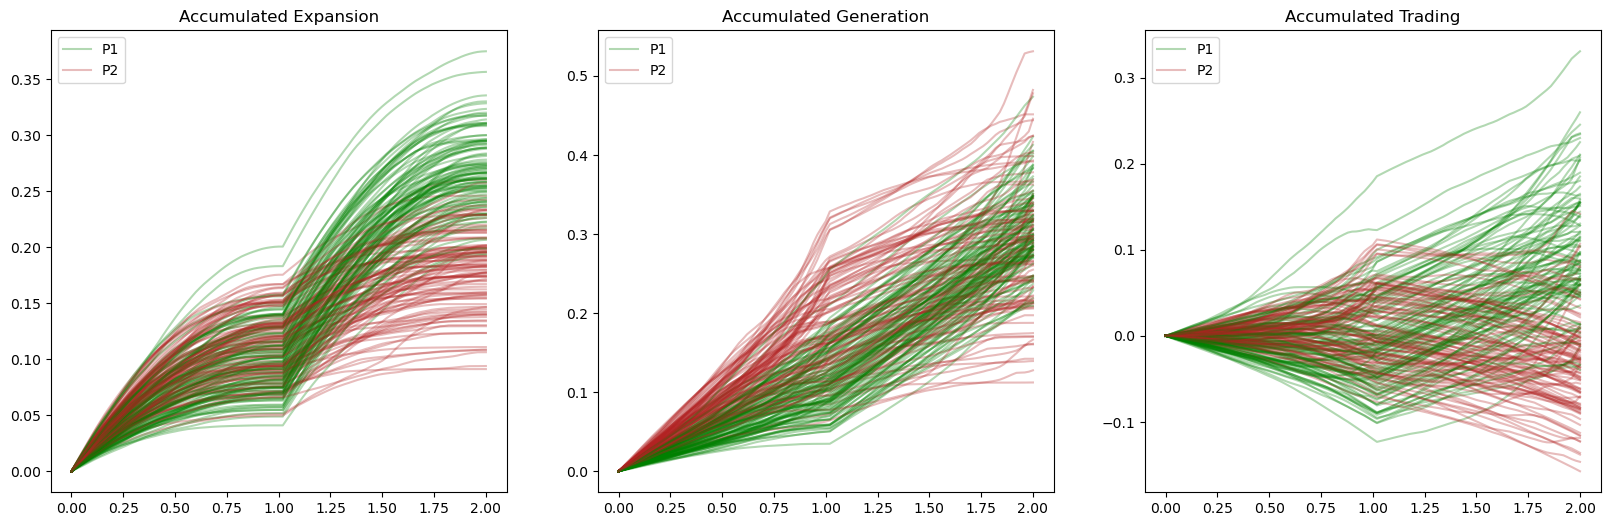

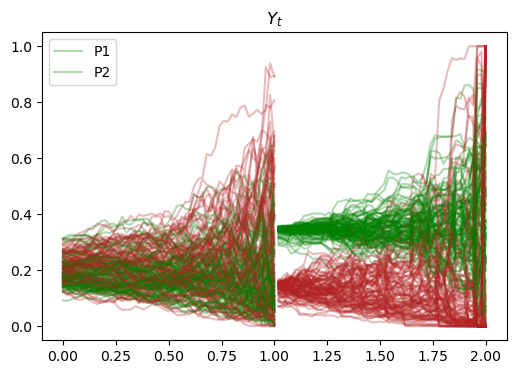

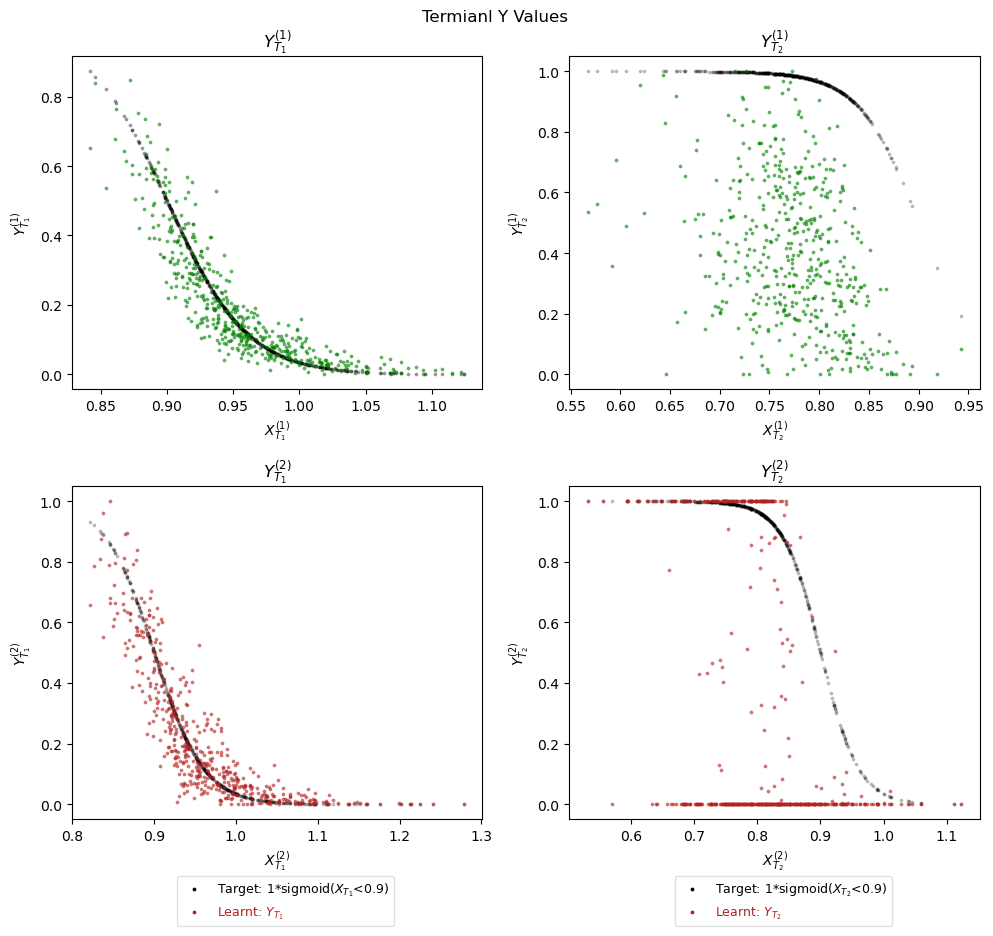

In [4]:
plot=plot_results(pop1_dict=pop1_dict, pop2_dict=pop2_dict, loss=forward_losses)
plot.FwdLoss(log=True)
plot.Inventory_And_Price()
plot.Decomposition_Inventory()
plot.Key_Processes()
plot.Terminal_Convergence()

## Save The Models

In [5]:
print(f"{len(main_models1.loss)} steps\nStarted @ {start_time}\nSaved @ {end_time}")   ## to examine whether the loss attribute is updated in the module insteance
dir_path=pathlib.Path(os.getcwd(),
                      'Results',
                      'Best Models Saved',
                      'sigmoid_sig_0.001lr_0.03delta_500steps_MSE_1w')  # 0.25, 0.5, 0.75  ## 0.01delta
dir_path.mkdir()
path1=pathlib.Path(dir_path,'pop1.pt')
path2=pathlib.Path(dir_path,'pop2.pt')
main_models1.save_entire_models(path=path1)
main_models2.save_entire_models(path=path2)

500 steps
Started @ September 16 - 10:36:45
Saved @ September 16 - 23:10:28


## Load The Models

In [6]:
# # GlobalParams1=Params(param_type='k1',target_type='indicator',trick='clamp',loss_type='MSELoss',delta=0.03,K=0.9,lr=0.01)
# # GlobalParams2=Params(param_type='k2',target_type='indicator',trick='clamp',loss_type='MSELoss',delta=0.03,K=0.9,lr=0.01)
# models1=Main_Models(GlobalParams=GlobalParams1)
# models2=Main_Models(GlobalParams=GlobalParams2)
# path_dir=pathlib.Path(os.getcwd(),
#                       "Results",
#                       "Best Models Saved",
#                       'sigmoid_sig_0.0001lr_0.01delta_500steps_MSE_0.5w')
# path1=pathlib.Path(path_dir,'pop1.pt')
# path2=pathlib.Path(path_dir,'pop2.pt')
# model_dict1=models1.load_entire_models(path=path1,overwrite=True)
# model_dict2=models2.load_entire_models(path=path2,overwrite=True)

# dB1=model_dict1['dB']
# init_x1=model_dict1['init_x']
# init_c1=model_dict1['init_c']
# pop1_dict= {'dB':dB1,
#             'init_x':init_x1,
#             'init_c':init_c1,
#             'GlobalParams':GlobalParams1, 
#             'main_models':models1}

# dB2=model_dict2['dB']
# init_x2=model_dict2['init_x']
# init_c2=model_dict2['init_c']

# pop2_dict= {'dB':dB2,
#             'init_x':init_x2 ,
#             'init_c':init_c2 , 
#             'GlobalParams':GlobalParams2, 
#             'main_models':models2}
# dt=GlobalParams1.dt
# NT1=GlobalParams1.NT1
# NT2=GlobalParams1.NT2
# NumTrain=GlobalParams1.NumTrain
# K=GlobalParams1.K
# loss=models1.loss

# plot=plot_results(pop1_dict=pop1_dict, pop2_dict=pop2_dict, loss=loss)
# plot.FwdLoss(log=True)
# plot.Decomposition_Inventory()
# plot.Inventory_And_Price()
# plot.Terminal_Convergence()
# plot.Key_Processes()